# Named Entity Recognition with CRF on CoNLL-2003 dataset

# 1. Data Loading and Overview
- Dataset: https://huggingface.co/datasets/eriktks/conll2003

In [106]:
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from datasets import load_dataset
from seqeval.metrics import f1_score, classification_report
from seqeval.metrics import f1_score as seqeval_f1_score, classification_report as seqeval_classification_report



In [107]:
# Load CoNLL-2003 dataset
dataset = load_dataset("eriktks/conll2003")
print(dataset)

train_data = dataset['train']
valid_data = dataset['validation']
test_data = dataset['test']

Found cached dataset conll2003 (/Users/peiyulin/.cache/huggingface/datasets/eriktks___conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})


In [108]:
# Check the first  examples
train_data[0]
# print(valid_data[:2])
# print(test_data[:2])

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

In [109]:
# Get the mapping from integer labels to actual NER tags (e.g., 'O', 'B-PER', etc.)
ner_tag_names = dataset['train'].features['ner_tags'].feature.names

ner_tag_names 

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

## Data Features and Tags

- id: a string feature.

- tokens: a list of string features.

- pos_tags: a list of classification labels (int). Full tagset with indices:
`{'"': 0, "''": 1, '#': 2, '$': 3, '(': 4, ')': 5, ',': 6, '.': 7, ':': 8, '``': 9, 'CC': 10, 'CD': 11, 'DT': 12, 'EX': 13, 'FW': 14, 'IN': 15, 'JJ': 16, 'JJR': 17, 'JJS': 18, 'LS': 19, 'MD': 20, 'NN': 21, 'NNP': 22, 'NNPS': 23, 'NNS': 24, 'NN|SYM': 25, 'PDT': 26, 'POS': 27, 'PRP': 28, 'PRP$': 29, 'RB': 30, 'RBR': 31, 'RBS': 32, 'RP': 33, 'SYM': 34, 'TO': 35, 'UH': 36, 'VB': 37, 'VBD': 38, 'VBG': 39, 'VBN': 40, 'VBP': 41, 'VBZ': 42, 'WDT': 43, 'WP': 44, 'WP$': 45, 'WRB': 46}`



- chunk_tags: a list of classification labels (int). Full tagset with indices:
`{'O': 0, 'B-ADJP': 1, 'I-ADJP': 2, 'B-ADVP': 3, 'I-ADVP': 4, 'B-CONJP': 5, 'I-CONJP': 6, 'B-INTJ': 7, 'I-INTJ': 8,
 'B-LST': 9, 'I-LST': 10, 'B-NP': 11, 'I-NP': 12, 'B-PP': 13, 'I-PP': 14, 'B-PRT': 15, 'I-PRT': 16, 'B-SBAR': 17,
 'I-SBAR': 18, 'B-UCP': 19, 'I-UCP': 20, 'B-VP': 21, 'I-VP': 22}`

- ner_tags: a list of classification labels (int). Full tagset with indices:
`{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}`

# 2.Feature Engineering

### Prefix and suffix
I additionally incorporated the first 2–3 and last 2–3 characters of each word as features, which led to a slight improvement in the model's F1-score. This suggests that the prefix and suffix of a word provide useful contextual information for NER.

However, when I further included only the first and last character of each word as features, the F1-score decreased instead. This indicates that considering only the very first and last character introduces noise rather than contributing meaningful information.

In [110]:
# Feature extraction function
def word2features(tokens, pos_tags, chunk_tags, i):
    """Extract features for a given word in a sentence."""
    word = tokens[i]
    postag = pos_tags[i]
    chunktag = chunk_tags[i]

    # Basic Features
    features = {
        'word.lower()': word.lower(),
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'word[-3:]': word[-3:],  
        'word[-2:]': word[-2:],  
        # 'word[-1:]': word[-1:],  # not helpful
        'word[:3]': word[:3],  
        'word[:2]': word[:2],    
        # 'word[:1]': word[:1],    # not helpful
        'postag': postag,
        'chunktag': chunktag,
    }

    # Features from the previous word
    if i > 0:
        features.update({
            '-1:word.lower()': tokens[i - 1].lower(),
            '-1:postag': pos_tags[i - 1],
            '-1:chunktag': chunk_tags[i - 1],
        })
    else:
        features['BOS'] = True  # Beginning of sentence

    # Features from the next word
    if i < len(tokens) - 1:
        features.update({
            '+1:word.lower()': tokens[i + 1].lower(),
            '+1:postag': pos_tags[i + 1],
            '+1:chunktag': chunk_tags[i + 1],
        })
    else:
        features['EOS'] = True  # End of sentence

    return features

def sent2features(tokens, pos_tags, chunk_tags):
    """Convert a sentence into feature vectors."""
    return [word2features(tokens, pos_tags, chunk_tags, i) for i in range(len(tokens))]

def sent2labels(ner_tags):
    """Convert integer NER labels to actual string labels for CRF training."""
    return [ner_tag_names[label] for label in ner_tags]


In [111]:
X_train = [sent2features(tokens, pos_tags, chunk_tags) for tokens, pos_tags,chunk_tags in zip(train_data['tokens'], train_data['pos_tags'],train_data['chunk_tags'])]
y_train = [sent2labels(tags) for tags in train_data['ner_tags']]

X_valid = [sent2features(tokens, pos_tags, chunk_tags) for tokens, pos_tags,chunk_tags in zip(valid_data['tokens'], valid_data['pos_tags'],valid_data['chunk_tags'])]
y_valid = [sent2labels(tags) for tags in valid_data['ner_tags']]

X_test = [sent2features(tokens, pos_tags, chunk_tags) for tokens, pos_tags,chunk_tags in zip(test_data['tokens'], test_data['pos_tags'],test_data['chunk_tags'])]
y_test = [sent2labels(tags) for tags in test_data['ner_tags']]

In [112]:
X_train[0]

[{'word.lower()': 'eu',
  'word.isupper()': True,
  'word.istitle()': False,
  'word.isdigit()': False,
  'word[-3:]': 'EU',
  'word[-2:]': 'EU',
  'word[:3]': 'EU',
  'word[:2]': 'EU',
  'postag': 22,
  'chunktag': 11,
  'BOS': True,
  '+1:word.lower()': 'rejects',
  '+1:postag': 42,
  '+1:chunktag': 21},
 {'word.lower()': 'rejects',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'word[-3:]': 'cts',
  'word[-2:]': 'ts',
  'word[:3]': 'rej',
  'word[:2]': 're',
  'postag': 42,
  'chunktag': 21,
  '-1:word.lower()': 'eu',
  '-1:postag': 22,
  '-1:chunktag': 11,
  '+1:word.lower()': 'german',
  '+1:postag': 16,
  '+1:chunktag': 11},
 {'word.lower()': 'german',
  'word.isupper()': False,
  'word.istitle()': True,
  'word.isdigit()': False,
  'word[-3:]': 'man',
  'word[-2:]': 'an',
  'word[:3]': 'Ger',
  'word[:2]': 'Ge',
  'postag': 16,
  'chunktag': 11,
  '-1:word.lower()': 'rejects',
  '-1:postag': 42,
  '-1:chunktag': 21,
  '+1:word.lower()': 'call'

In [113]:
y_train[0]

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

# 3. Model Training

In [114]:
# Train CRF model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,  # L1 regularization
    c2=0.2,  # L2 regularization
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.2,
    max_iterations=100)

# 4. Model Evaluation

## Use F1_score as Metric
- Balances Precision & Recall: Ensures both correct identification and coverage of entities.
- Handles Class Imbalance: Useful when entity occurrences vary.
- Single Performance Metric: Provides a unified measure for comparison.


In [115]:
# Evaluate the model on the valid set with CRF
y_valid_pred = crf.predict(X_valid)

# Print entity-level classification report
print("Entity-level classification report on validation set:")
print(seqeval_classification_report(y_valid, y_valid_pred))

# Print entity-level F1 score
print("Entity-level F1 score on validation set: {:.4f}".format(seqeval_f1_score(y_valid, y_valid_pred)))


Entity-level classification report on validation set:
              precision    recall  f1-score   support

         LOC       0.92      0.88      0.90      1837
        MISC       0.92      0.83      0.87       922
         ORG       0.84      0.79      0.81      1341
         PER       0.90      0.88      0.89      1842

   micro avg       0.89      0.85      0.87      5942
   macro avg       0.89      0.84      0.87      5942
weighted avg       0.89      0.85      0.87      5942

Entity-level F1 score on validation set: 0.8716


In [116]:
# Evaluate the model on the test set with CRF
y_test_pred = crf.predict(X_test)

# Print entity-level classification report
print("Entity-level classification report:")
print(seqeval_classification_report(y_test, y_test_pred))

# Print entity-level F1 score
print("Entity-level F1 score on test set: {:.4f}".format(seqeval_f1_score(y_test, y_test_pred)))


Entity-level classification report:
              precision    recall  f1-score   support

         LOC       0.84      0.82      0.83      1668
        MISC       0.80      0.73      0.76       702
         ORG       0.77      0.66      0.71      1661
         PER       0.83      0.83      0.83      1617

   micro avg       0.81      0.77      0.79      5648
   macro avg       0.81      0.76      0.78      5648
weighted avg       0.81      0.77      0.79      5648

Entity-level F1 score on test set: 0.7892


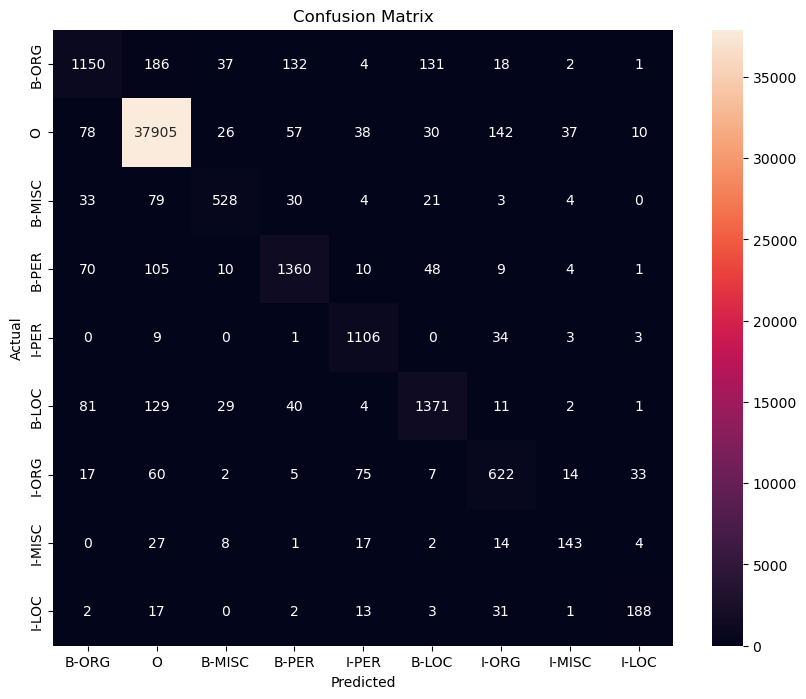

In [117]:
from sklearn.metrics import confusion_matrix
import numpy as np

labels = list(crf.classes_)
y_true = np.concatenate(y_test)
y_pred = np.concatenate(y_test_pred)

conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# 5. Hyperparameter Fine-tuning

### Fine-tune c1 and c2
- Best parameters by GridSearchCV is c1=0.01, c2=0.01
- Compared to c1=0.1,c2=0.2, F1_score: 0.7892 -> 0.7914

In [119]:
# from sklearn_crfsuite import CRF
# from sklearn.model_selection import GridSearchCV
# from seqeval.metrics import f1_score as seqeval_f1_score
# from sklearn.metrics import make_scorer

# # Define a custom scoring function for entity-level F1-score
# def entity_f1_score(y_true, y_pred):
#     return seqeval_f1_score(y_true, y_pred)

# # Wrap it using make_scorer so GridSearchCV can use it
# f1_scorer = make_scorer(entity_f1_score)

# # Define the hyperparameter grid
# param_space = {
#     'c1': [0.01, 0.05, 0.1, 0.2],
#     'c2': [0.01, 0.05, 0.1, 0.2],
# }

# # Initialize CRF model
# crf = CRF(
#     algorithm='lbfgs',
#     max_iterations=100,
#     all_possible_transitions=True
# )

# # Perform Grid Search with the custom F1 scorer
# rs = GridSearchCV(crf, param_space, cv=3, verbose=1, n_jobs=-1, scoring=f1_scorer)
# rs.fit(X_train, y_train)

# # Print the best hyperparameters
# print("Best parameters:", rs.best_params_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'c1': 0.01, 'c2': 0.01}


In [125]:
# Train CRF model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.01,  # L1 regularization
    c2=0.01,  # L2 regularization
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

# Evaluate the model on the valid set with CRF
y_valid_pred = crf.predict(X_valid)

# Print entity-level classification report
print("Entity-level classification report on validation set:")
print(seqeval_classification_report(y_valid, y_valid_pred))

# Print entity-level F1 score
print("Entity-level F1 score on validation set: {:.4f}".format(seqeval_f1_score(y_valid, y_valid_pred)))

# Evaluate the model on the test set with CRF
y_test_pred = crf.predict(X_test)

# Print entity-level classification report
print("Entity-level classification report:")
print(seqeval_classification_report(y_test, y_test_pred))

# Print entity-level F1 score
print("Entity-level F1 score on test set: {:.4f}".format(seqeval_f1_score(y_test, y_test_pred)))

Entity-level classification report on validation set:
              precision    recall  f1-score   support

         LOC       0.92      0.89      0.90      1837
        MISC       0.91      0.83      0.87       922
         ORG       0.84      0.79      0.82      1341
         PER       0.90      0.89      0.90      1842

   micro avg       0.90      0.86      0.88      5942
   macro avg       0.89      0.85      0.87      5942
weighted avg       0.90      0.86      0.88      5942

Entity-level F1 score on validation set: 0.8770
Entity-level classification report:
              precision    recall  f1-score   support

         LOC       0.83      0.83      0.83      1668
        MISC       0.79      0.75      0.77       702
         ORG       0.76      0.67      0.72      1661
         PER       0.85      0.83      0.84      1617

   micro avg       0.81      0.77      0.79      5648
   macro avg       0.81      0.77      0.79      5648
weighted avg       0.81      0.77      0.79    

# 6. Misclassified Sample Analysis

In [44]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Analyze misclassified entities
errors = []
for y_true_seq, y_pred_seq, tokens in zip(y_test, y_test_pred, test_data['tokens']):
    for true_label, pred_label, token in zip(y_true_seq, y_pred_seq, tokens):
        if true_label != pred_label:
            errors.append((token, true_label, pred_label))

print(f"Total errors: {len(errors)}")
print(errors[:10])

Total errors: 2007
[('CHINA', '1', '5'), ('Uzbek', '7', '0'), ('Bitar', '1', '3'), ('Bitar', '1', '3'), ('CUTTITTA', '1', '0'), ('ITALY', '5', '0'), ('ROME', '5', '0'), ('Cuttitta', '1', '5'), ('Cuttitta', '1', '3'), ('1995', '7', '0')]


In [45]:
# Convert to DataFrame for better analysis
error_df = pd.DataFrame(errors, columns=['Token', 'True Label', 'Predicted Label'])
error_df.head()

# Count most common misclassifications
most_common_errors = error_df.groupby(['True Label', 'Predicted Label']).size().reset_index(name='Count')
most_common_errors = most_common_errors.sort_values(by='Count', ascending=False)

most_common_errors[:10]

,True Label,Predicted Label,Count
21,3,0,169
25,3,5,148
3,0,4,114
22,3,1,108
37,5,0,107
8,1,0,102
40,5,3,91
10,1,3,84
52,7,0,79
2,0,3,72


In [46]:
# Count misclassification per entity class
error_counts = error_df['True Label'].value_counts().reset_index()
error_counts.columns = ['NER Class', 'Misclassification Count']

error_counts

# map entity labels to their descriptions
label_map = {
    '0': 'O',
    '1': 'B-PER',
    '2': 'I-PER',
    '3': 'B-ORG',
    '4': 'I-ORG',
    '5': 'B-LOC',
    '6': 'I-LOC',
    '7': 'B-MISC',
    '8': 'I-MISC',
}

error_counts['NER Class'] = error_counts['NER Class'].map(label_map)
error_counts

,NER Class,Misclassification Count
0,B-ORG,498
1,O,376
2,B-PER,276
3,B-LOC,275
4,I-ORG,205
5,B-MISC,163
6,I-LOC,84
7,I-MISC,73
8,I-PER,57


In [47]:
# Analyze class imbalance in training data
all_labels = np.concatenate(train_data['ner_tags'])  # Flatten all labels in training set
label_counts = Counter(all_labels)

# Map label indices to actual NER class names
ner_label_map = {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'}
train_label_counts = {ner_label_map[key]: value for key, value in label_counts.items()}

# Convert to DataFrame
train_label_df = pd.DataFrame(list(train_label_counts.items()), columns=['NER Class', 'Count'])

# sort by count
train_label_df = train_label_df.sort_values(by='Count', ascending=False)

train_label_df['Percentage'] = (train_label_df['Count'] / train_label_df['Count'].sum() * 100).round(1)

train_label_df

,NER Class,Count,Percentage
1,O,169578,83.3
5,B-LOC,7140,3.5
3,B-PER,6600,3.2
0,B-ORG,6321,3.1
4,I-PER,4528,2.2
6,I-ORG,3704,1.8
2,B-MISC,3438,1.7
8,I-LOC,1157,0.6
7,I-MISC,1155,0.6
